# Data Preparation

In [6]:
import warnings
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna.integration.lightgbm as lgb          ####
from lightgbm import LGBMRegressor, plot_metric    #### 여기서 lgb로 안가져옴
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error, median_absolute_error

In [7]:
# options
pd.set_option('max_columns',100)
plt.style.use('fivethirtyeight')
warnings.simplefilter('ignore')
seed = 1

In [8]:
# Data dirctory
data_dir = Path('../data/')
data_file = data_dir / 'data.csv'
input_dir = Path('../input/')

In [9]:
# Data
# 0:AAR / 1:EAD / 2:ADR / 3:EDD는 고정  , 나머지는 순서 상관 없음

In [10]:
Data = pd.read_csv(data_file, index_col=0)
Data_6 = pd.read_csv(data_dir / 'data_6.csv' , index_col=0)
Data_12 = pd.read_csv(data_dir / 'data_12.csv', index_col=0)
Data_18 = pd.read_csv(data_dir / 'data_18.csv', index_col=0)
Data_24 = pd.read_csv(data_dir / 'data_24.csv', index_col=0)

Validation <br><br>

sklearn.model_selection
* train_test_split
* KFold
* StratifiedKFold

<br>
<br>
lightGBM <br>
* lgb.cv    # 쓰려면 lightgbm을 lgb로 import

***
***
***

# LightGBM fitting

## Data Split

In [11]:
# 예측할 시간에 맞는 Data로 넣기
# 0-6 : Data_6 / 6-12 : Data_12 / 12-18 : Data_18 / 18-24 : Data_24
Data_raw = Data_6
Data_m = Data_6
Data_m = Data_m.drop('AAR', axis=1)
Data_m = Data_m.drop('ADR', axis=1)


# Arrival
y_a = Data_raw.AAR.to_numpy()
X_a = Data_m.to_numpy()
#X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size = 0.1, random_state = seed)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size = 0.1, random_state = seed)
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.11, random_state = 13) 


# Departure
y_d = Data_raw.ADR.to_numpy()
X_d = Data_m.to_numpy()
#X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size = 0.1, random_state = seed)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size = 0.1, random_state = seed)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.11, random_state = 13) 

# val은 hyperparameter 검증에 사용
# 0.11 x 0.9 = 0.099

print('Training Data shape : ', Data_m.shape)
Data_m.head()

Training Data shape :  (26304, 46)


,EAD,EDD,year,month,day,hour,DayName,Arpt_cond,P_Airp,P_AAR,P_ADR,Arrival_remainder,Departure_remainder,WD_850,WD_925,WD_1000,WS_850,WS_925,WS_1000,WD,WSPD,WS_GST,VIS,WC,RN,CA_TOT,CLA_1LYR,BASE_1LYR,CLA_2LYR,BASE_2LYR,CLA_3LYR,BASE_3LYR,CLA_4LYR,BASE_4LYR,RVR,WDIR_t6,WSPD_t6,WG_t6,VIS_t6,WC_t6,CLA_1LYR_t6,BASE_1LYR_t6,CLA_2LYR_t6,BASE_2LYR_t6,CLA_3LYR_t6,BASE_3LYR_t6
0,2.0,11.0,2018,1,1,0,1,1.0,1.0,0.0,0.0,0.0,0.0,320.0,325.0,245.0,28.0,19.0,3.0,34,5,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
1,1.0,5.0,2018,1,1,1,1,1.0,1.0,3.0,11.0,0.0,0.0,320.0,325.0,245.0,28.0,19.0,3.0,3,1,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
2,1.0,4.0,2018,1,1,2,1,1.0,1.0,0.0,4.0,1.0,1.0,320.0,325.0,245.0,28.0,19.0,3.0,35,1,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
3,0.0,1.0,2018,1,1,3,1,1.0,1.0,0.0,4.0,1.0,0.0,320.0,325.0,245.0,28.0,19.0,3.0,0,0,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
4,16.0,1.0,2018,1,1,4,1,1.0,1.0,2.0,1.0,0.0,0.0,320.0,325.0,245.0,28.0,19.0,3.0,19,1,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0


***
## Hyperparameter Optimization

In [12]:
# Hyperparameters
params = {'boosting_type' : 'gbdt',            # 'dart' 는 계산시간 길어짐, early stopping X / 'rf’ : Random Forest
          'metric': 'mse',
          'num_leaves' : 127,                  ## Maximum tree leaves for base learners (31)
          'max_depth' : - 1,                   # Maximum tree depth for base learners, <=0 means no limit (-1)
          'learning_rate' : 0.001,             ## Boosting learning rate (0.1)
          'n_estimators' : 10000000,           # Number of boosted trees to fit (100) -> fit에서 early stopping으로 제한해서 크게 설정함
          'subsample_for_bin' : 200000,        # Number of samples for constructing bins (200000)
          'objective' : 'regression',          # learning task and the corresponding learning objective (None)
          'class_weight' : None,               # * Use this parameter only for multi-class classification task
          'min_split_gain' : 0.0,              # Minimum loss reduction required to make a further partition on a leaf node of the tree (0)
          'min_child_weight' : 0.001,          # Minimum sum of instance weight (hessian) needed in a child (leaf) (0.001)
          'min_child_samples' : 1,             # Minimum number of data needed in a child (leaf) (20) - 마지막노드(리프)에 최소 몇가지 샘플이 있어야 하는지 
          'subsample' : 0.8,                   ## Subsample ratio of the training instance (1.0) - 개별 트리를 학습시키는데 몇 %의 데이터를 사용할 것 인지, row sampling
          'subsample_freq' : 1,                # Frequency of subsample, <=0 means no enable (0) - 몇개의 트리마다 subsampling을 할 것인지
          'colsample_bytree' : 0.8,            ## Subsample ratio of columns when constructing each tree (1.0) - 몇 %의 column을 sampling 할 것인지
          'reg_alpha' : 0.0,                   # L1 regularization term on weights (0)
          'reg_lambda' : 0.0,                  # L2 regularization term on weights (0)
          'random_state' : seed,               # Random number seed (None)
          'n_jobs' : - 1,                      # Number of parallel threads (-1) - 몇 개의 병렬작업을 할 것인지 (-1 = 모든 가능한 것 전부)
          'silent' : True,                     # Whether to print messages while running boosting (True)
          'importance_type' : 'split'}         # ‘split’: result contains numbers of times the feature is used in a model
                                               # ‘gain’ : result contains total gains of splits which use the feature

# 최적 hyperparameter 찾기!!

In [13]:
# Hyperparameters - arrival
params_a = {'boosting_type' : 'gbdt',                   # 'dart' 는 계산시간 길어짐, early stopping X / 'rf’ : Random Forest
            'metric': 'mse',
            'num_leaves' : 127,                          ## Maximum tree leaves for base learners (31)
            'max_depth' : - 1,                          # Maximum tree depth for base learners, <=0 means no limit (-1)
            'learning_rate' : 0.001,                    ## Boosting learning rate (0.1)
            'n_estimators' : 1000000,                   # Number of boosted trees to fit (100) -> fit에서 early stopping으로 제한해서 크게 설정함
            'subsample_for_bin' : 200000,               # Number of samples for constructing bins (200000)
            'objective' : 'regression',                 # learning task and the corresponding learning objective (None)
            'class_weight' : None,                      # * Use this parameter only for multi-class classification task
            'min_split_gain' : 0.0,                     # Minimum loss reduction required to make a further partition on a leaf node of the tree (0)
            'min_child_weight' : 0.001,                 # Minimum sum of instance weight (hessian) needed in a child (leaf) (0.001)
            'min_child_samples' : 1,                    # Minimum number of data needed in a child (leaf) (20) - 마지막노드(리프)에 최소 몇가지 샘플이 있어야 하는지 
            'feature_pre_filter': False,
            'subsample' : 0.98,           ## Subsample ratio of the training instance (1.0) - 개별 트리를 학습시키는데 몇 %의 데이터를 사용할 것 인지, row sampling
            'subsample_freq' : 1,   #3                  # Frequency of subsample, <=0 means no enable (0) - 몇개의 트리마다 subsampling을 할 것인지
            'colsample_bytree' : 0.72,    ## Subsample ratio of columns when constructing each tree (1.0) - 몇 %의 column을 sampling 할 것인지
            'reg_alpha' : 1.5174152626537185,       # L1 regularization term on weights (0)
            'reg_lambda' : 5.0986611213704176e-06,           # L2 regularization term on weights (0)
            'random_state' : seed,                      # Random number seed (None)
            'n_jobs' : - 1,                             # Number of parallel threads (-1) - 몇 개의 병렬작업을 할 것인지 (-1 = 모든 가능한 것 전부)
            'silent' : True,                            # Whether to print messages while running boosting (True)
            'importance_type' : 'split'}                # ‘split’: result contains numbers of times the feature is used in a model
                                                        # ‘gain’ : result contains total gains of splits which use the feature

In [14]:
# Optuna 간단 버전 - arrival

"""y = Data_raw.AAR.to_numpy()
X = Data_m.to_numpy()

X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X, y, test_size=.2, random_state=seed)

dtrain_a = lgb.Dataset(X_train_a, label = y_train_a)
dval_a = lgb.Dataset(X_val_a, label = y_val_a)

model = lgb.train(params, dtrain_a,
                  valid_sets=[dtrain_a, dval_a], 
                  verbose_eval=100,
                  early_stopping_rounds=10)

prediction = model.predict(X_val_a, num_iteration=model.best_iteration)

accuracy = r2_score(y_val_a, prediction)        # classification이면 앞에 argmax( , axis = 1)로 하면 될 듯



params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

params_a = params"""

'y = Data_raw.AAR.to_numpy()\nX = Data_m.to_numpy()\n\nX_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X, y, test_size=.2, random_state=seed)\n\ndtrain_a = lgb.Dataset(X_train_a, label = y_train_a)\ndval_a = lgb.Dataset(X_val_a, label = y_val_a)\n\nmodel = lgb.train(params, dtrain_a,\n                  valid_sets=[dtrain_a, dval_a], \n                  verbose_eval=100,\n                  early_stopping_rounds=10)\n\nprediction = model.predict(X_val_a, num_iteration=model.best_iteration)\n\naccuracy = r2_score(y_val_a, prediction)        # classification이면 앞에 argmax( , axis = 1)로 하면 될 듯\n\n\n\nparams = model.params\nprint("Best params:", params)\nprint("  Accuracy = {}".format(accuracy))\nprint("  Params: ")\nfor key, value in params.items():\n    print("    {}: {}".format(key, value))\n\nparams_a = params'

In [15]:
# Hyperparameters - departure
params_d = {'boosting_type' : 'gbdt',                 # 'dart' 는 계산시간 길어짐, early stopping X / 'rf’ : Random Forest
            'metric': 'mse',
            'num_leaves' : 127,                        ## Maximum tree leaves for base learners (31)
            'max_depth' : - 1,                        # Maximum tree depth for base learners, <=0 means no limit (-1)
            'learning_rate' : 0.001,                  ## Boosting learning rate (0.1)
            'n_estimators' : 1000000,                 # Number of boosted trees to fit (100) -> fit에서 early stopping으로 제한해서 크게 설정함
            'subsample_for_bin' : 200000,             # Number of samples for constructing bins (200000)
            'objective' : 'regression',               # learning task and the corresponding learning objective (None)
            'class_weight' : None,                    # * Use this parameter only for multi-class classification task
            'min_split_gain' : 0.0,                   # Minimum loss reduction required to make a further partition on a leaf node of the tree (0)
            'min_child_weight' : 0.001,               # Minimum sum of instance weight (hessian) needed in a child (leaf) (0.001)
            'min_child_samples' : 1,                  # Minimum number of data needed in a child (leaf) (20) - 마지막노드(리프)에 최소 몇가지 샘플이 있어야 하는지 
            'feature_pre_filter': False,
            'subsample' : 0.99,         ## Subsample ratio of the training instance (1.0) - 개별 트리를 학습시키는데 몇 %의 데이터를 사용할 것 인지, row sampling
            'subsample_freq' : 1,    #3               # Frequency of subsample, <=0 means no enable (0) - 몇개의 트리마다 subsampling을 할 것인지
            'colsample_bytree' : 0.8,  ## Subsample ratio of columns when constructing each tree (1.0) - 몇 %의 column을 sampling 할 것인지
            'reg_alpha' :  1.4025647727814503,     # L1 regularization term on weights (0)
            'reg_lambda' : 1.0819342779766032e-08,      # L2 regularization term on weights (0)
            'random_state' : seed,                    # Random number seed (None)
            'n_jobs' : - 1,                           # Number of parallel threads (-1) - 몇 개의 병렬작업을 할 것인지 (-1 = 모든 가능한 것 전부)
            'silent' : True,                          # Whether to print messages while running boosting (True)
            'importance_type' : 'split'}              # ‘split’: result contains numbers of times the feature is used in a model
                                                      # ‘gain’ : result contains total gains of splits which use the feature

In [16]:
# Optuna 간단 버전 - departure


"""y = Data_raw.ADR.to_numpy()
X = Data_m.to_numpy()

X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X, y, test_size=.2, random_state=seed)

dtrain_d = lgb.Dataset(X_train_d, label = y_train_d)
dval_d = lgb.Dataset(X_val_d, label = y_val_d)

model = lgb.train(params, dtrain_d,
                  valid_sets=[dtrain_d, dval_d], 
                  verbose_eval=100,
                  early_stopping_rounds=10)

prediction = model.predict(X_val_d, num_iteration=model.best_iteration)

accuracy = r2_score(y_val_d, prediction)         # classification이면 앞에 argmax( , axis = 1)로 하면 될 듯

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

params_d = params"""


'y = Data_raw.ADR.to_numpy()\nX = Data_m.to_numpy()\n\nX_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X, y, test_size=.2, random_state=seed)\n\ndtrain_d = lgb.Dataset(X_train_d, label = y_train_d)\ndval_d = lgb.Dataset(X_val_d, label = y_val_d)\n\nmodel = lgb.train(params, dtrain_d,\n                  valid_sets=[dtrain_d, dval_d], \n                  verbose_eval=100,\n                  early_stopping_rounds=10)\n\nprediction = model.predict(X_val_d, num_iteration=model.best_iteration)\n\naccuracy = r2_score(y_val_d, prediction)         # classification이면 앞에 argmax( , axis = 1)로 하면 될 듯\n\nparams = model.params\nprint("Best params:", params)\nprint("  Accuracy = {}".format(accuracy))\nprint("  Params: ")\nfor key, value in params.items():\n    print("    {}: {}".format(key, value))\n\nparams_d = params'

***
## Arrival

In [17]:
# Model fitting
reg_arrival = LGBMRegressor(**params_a)

reg_arrival.fit(X_train_a, y_train_a,
                sample_weight = None,                   # Weights of training data
                init_score = None,                      # Weights of training data
                eval_set = [(X_val_a, y_val_a)],        # pairs to use as validation sets
                eval_sample_weight = None,              # Weights of eval data
                eval_init_score = None,                 # Init score of eval data.   
                eval_metric = 'l2',                     # Default: ‘l2’ for LGBMRegressor, ‘logloss’ for LGBMClassifier
                early_stopping_rounds = 10,             # loss fuction이 n번 이상 좋아지지 않으면 멈춰라
                verbose = False)            

LGBMRegressor(colsample_bytree=0.72, feature_pre_filter=False,
              learning_rate=0.001, metric='mse', min_child_samples=1,
              n_estimators=1000000, num_leaves=127, objective='regression',
              random_state=1, reg_alpha=1.5174152626537185,
              reg_lambda=5.0986611213704176e-06, subsample=0.98,
              subsample_freq=1)

***
##  Departure

In [18]:
# Model fitting
reg_departure = LGBMRegressor(**params_d)

reg_departure.fit(X_train_d, y_train_d,
                  eval_set=[(X_val_d, y_val_d)],
                  eval_metric='l2',
                  early_stopping_rounds = 10, 
                  verbose = False)     # loss fuction이 n번 이상 좋아지지 않으면 멈춰라

LGBMRegressor(colsample_bytree=0.8, feature_pre_filter=False,
              learning_rate=0.001, metric='mse', min_child_samples=1,
              n_estimators=1000000, num_leaves=127, objective='regression',
              random_state=1, reg_alpha=1.4025647727814503,
              reg_lambda=1.0819342779766032e-08, subsample=0.99,
              subsample_freq=1)

***

## Cross validation

for loop안에서 predict하고 평균을 내야 함 <br>
-> demand를 하나씩 증가시키리면, 바로 CV를 사용하기는 어려울 듯

In [19]:
"""
n_fold = 10

cv = KFold(n_splits=n_fold, shuffle=True, random_state=seed)

p_val_a = np.zeros(X_a.shape[0])
predict_a = np.zeros(X_a.shape[0])
p_val_d = np.zeros(X_d.shape[0])
predict_d = np.zeros(X_d.shape[0])

############### 위에서 X_val_a등으로 바꾼 거 없애고 -> 아래 X_a, y_a, X_d, y_d를 X_train_a 등으로 바꾸기 #######################

for i, (i_trn, i_val) in enumerate(cv.split(X_a, y_a), 1):        # 몇번째인지 보기 위해 enumerate 사용
    print('----------------------------------------------------------------------------')
    print(f'Training model for Cross-Validation #{i}')
    reg_arrival = LGBMRegressor(**params)    #############params_a
    reg_arrival.fit(X_a[i_trn], y_a[i_trn],
                sample_weight = None,                   # Weights of training data
                init_score = None,                      # Weights of training data
                eval_set = [(X_a[i_val], y_a[i_val])],  # pairs to use as validation sets
                eval_sample_weight = None,              # Weights of eval data
                eval_init_score = None,                 # Init score of eval data.   
                eval_metric = 'l2',                     # Default: ‘l2’ for LGBMRegressor, ‘logloss’ for LGBMClassifier, ‘ndcg’ for LGBMRanker
                early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라
    
    p_val_a[i_val] = reg_arrival.predict(X_a[i_val])
    predict_a += reg_arrival.predict(X_a) / n_fold      ##### 이 자리에 원래는 test data가 들어가면 됨
                                                        # test data의 prediction은 CV에서 각 dataset이 예측한 값들의 평균이므로
    
for i, (i_trn, i_val) in enumerate(cv.split(X_d, y_d), 1):        # 몇번째인지 보기 위해 enumerate 사용
    print('----------------------------------------------------------------------------')
    print(f'Training model for Cross-Validation #{i}')
    reg_departure = LGBMRegressor(**params)    #############params_d
    reg_departure.fit(X_d[i_trn], y_d[i_trn],
                      sample_weight = None,                   # Weights of training data
                      init_score = None,                      # Weights of training data
                      eval_set = [(X_d[i_val], y_d[i_val])],  # pairs to use as validation sets
                      eval_sample_weight = None,              # Weights of eval data
                      eval_init_score = None,                 # Init score of eval data.   
                      eval_metric = 'l2',                     # Default: ‘l2’ for LGBMRegressor, ‘logloss’ for LGBMClassifier, ‘ndcg’ for LGBMRanker
                      early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라
    
    p_val_d[i_val] = reg_departure.predict(X_d[i_val])
    predict_d += reg_departure.predict(X_d) / n_fold          ##### 이 자리에 원래는 test data가 들어가면 됨
                                                              # test data의 prediction은 CV에서 각 dataset이 예측한 값들의 평균이므로
"""

"\nn_fold = 10\n\ncv = KFold(n_splits=n_fold, shuffle=True, random_state=seed)\n\np_val_a = np.zeros(X_a.shape[0])\npredict_a = np.zeros(X_a.shape[0])\np_val_d = np.zeros(X_d.shape[0])\npredict_d = np.zeros(X_d.shape[0])\n\n############### 위에서 X_val_a등으로 바꾼 거 없애고 -> 아래 X_a, y_a, X_d, y_d를 X_train_a 등으로 바꾸기 #######################\n\nfor i, (i_trn, i_val) in enumerate(cv.split(X_a, y_a), 1):        # 몇번째인지 보기 위해 enumerate 사용\n    print('----------------------------------------------------------------------------')\n    print(f'Training model for Cross-Validation #{i}')\n    reg_arrival = LGBMRegressor(**params)    #############params_a\n    reg_arrival.fit(X_a[i_trn], y_a[i_trn],\n                sample_weight = None,                   # Weights of training data\n                init_score = None,                      # Weights of training data\n                eval_set = [(X_a[i_val], y_a[i_val])],  # pairs to use as validation sets\n                eval_sample_weight = None,          

In [20]:
"""
print(f'Arrival RMSE : {np.sqrt(mean_squared_error(y_a, predict_a)):.4f}')
print(f'Arrival Training R^2 : {r2_score(y_a, predict_a) * 100:.4f}')
print(f'Departure RMSE : {np.sqrt(mean_squared_error(y_d, predict_d)):.4f}')
print(f'Departure Training R^2 : {r2_score(y_d, predict_d) * 100:.4f}')

np.savetxt('p_val_a.csv', p_val_a, fmt='%.6f', delimiter=',')
np.savetxt('p_val_d.csv', p_val_d, fmt='%.6f', delimiter=',')
np.savetxt('predict_a.csv', predict_a, fmt='%.6f', delimiter=',')
np.savetxt('predict_d.csv', predict_d, fmt='%.6f', delimiter=',')
"""

"\nprint(f'Arrival RMSE : {np.sqrt(mean_squared_error(y_a, predict_a)):.4f}')\nprint(f'Arrival Training R^2 : {r2_score(y_a, predict_a) * 100:.4f}')\nprint(f'Departure RMSE : {np.sqrt(mean_squared_error(y_d, predict_d)):.4f}')\nprint(f'Departure Training R^2 : {r2_score(y_d, predict_d) * 100:.4f}')\n\nnp.savetxt('p_val_a.csv', p_val_a, fmt='%.6f', delimiter=',')\nnp.savetxt('p_val_d.csv', p_val_d, fmt='%.6f', delimiter=',')\nnp.savetxt('predict_a.csv', predict_a, fmt='%.6f', delimiter=',')\nnp.savetxt('predict_d.csv', predict_d, fmt='%.6f', delimiter=',')\n"

이렇게 각각의 model의(e.g. lightGBM, XGBOOST, Randomforest ...) Cross Validation을 예측한 결과와, Test data에 대해 예측한 결과를 파일로 저장 <br>
-> 다음 stage에서는 CV결과들을 input data로 사용, 기존의 label은 그대로 사용, test data의 예측값을 다음 stage에서 test data의 input으로 사용 <br>
-> 계속 쌓아갈 수 있음 (=Stacking, 보통 stage 1,2정도면 이후 효과는 미비)


stacking, ensemble 보다 feature engineering, hyperparameter tuning의 성능 향상이 훨씬 커서 앞의 방법은 굳이 사용하지 않아도 괜찮음

***
***
***

# Evaluation

<sklearn.metrics> <br>

* regression <br>
mean_squared_error, mean_absolute_error, r2_score <br><br>

* classification <br>
log_loss, roc_auc_score, accuracy_score, confusion_matrix <br>

In [21]:
def Test(Data_raw, ops='arrival', start=0, end = 10):        # ops : arrival , departure
    if ops == 'arrival':
        Data_raw = Data_raw.drop('ADR', axis=1)
        datelist = pd.DataFrame(pd.date_range('2019-01-01', '2019-12-31 23:00', freq = '1h'))
        test_result = pd.DataFrame({'Date' : datelist[start:end][0],
                                    'EAD' : Data_raw['EAD'][start:end],
                                    'Actual AAR' : Data_raw['AAR'][start:end], 
                                    'Predicted AAR' : reg_arrival.predict(Data_raw.drop('AAR', axis=1)[start:end]), 
                                    'Difference' : reg_arrival.predict(Data_raw.drop('AAR', axis=1)[start:end]) - Data_raw['AAR'][start:end]})
    elif ops == 'departure':
        Data_raw = Data_raw.drop('AAR', axis=1)        
        datelist = pd.DataFrame(pd.date_range('2019-01-01', '2019-12-31 23:00', freq = '1h'))
        test_result = pd.DataFrame({'Date' : datelist[start:end][0],
                                    'EDD' : Data_raw['EDD'][start:end],
                                    'Actual ADR' : Data_raw['ADR'][start:end], 
                                    'Predicted ADR' : reg_departure.predict(Data_raw.drop('ADR', axis=1)[start:end]), 
                                    'Difference' : reg_departure.predict(Data_raw.drop('ADR', axis=1)[start:end]) - Data_raw['ADR'][start:end]})
        
    return test_result

***
## Arrival

In [22]:
# Predict & Evaluation

y_hat_a = reg_arrival.predict(X_a)
print(f'Total RMSE : {np.sqrt(mean_squared_error(y_a, y_hat_a)):.4f}')

print(f'Training R^2 : {r2_score(y_train_a, reg_arrival.predict(X_train_a)) :.4f}')
print(f'Test R^2 : {r2_score(y_test_a, reg_arrival.predict(X_test_a)) :.4f}')

print(f'Training RMSE : {np.sqrt(mean_squared_error(y_train_a, reg_arrival.predict(X_train_a))):.4f}')
print(f'Test RMSE : {np.sqrt(mean_squared_error(y_test_a, reg_arrival.predict(X_test_a))):.4f}')
#print(f'explained variance score : {explained_variance_score(y_a, y_hat_a) :.4f}')
#print(f'max error : {max_error(y_a, y_hat_a) :.4f}')
#print(f'mean absolute error : {mean_absolute_error(y_a, y_hat_a) :.4f}')
#print(f'mean absolute percentage error : {mean_absolute_percentage_error(y_a, y_hat_a)}')
#print(f'mean squared log error : {mean_squared_log_error(y_a, y_hat_a) :.4f}')
#print(f'median absolute error : {median_absolute_error(y_a, y_hat_a) :.4f}')


Total RMSE : 2.1362
Training R^2 : 0.9731
Test R^2 : 0.9492
Training RMSE : 1.9688
Test RMSE : 2.7099


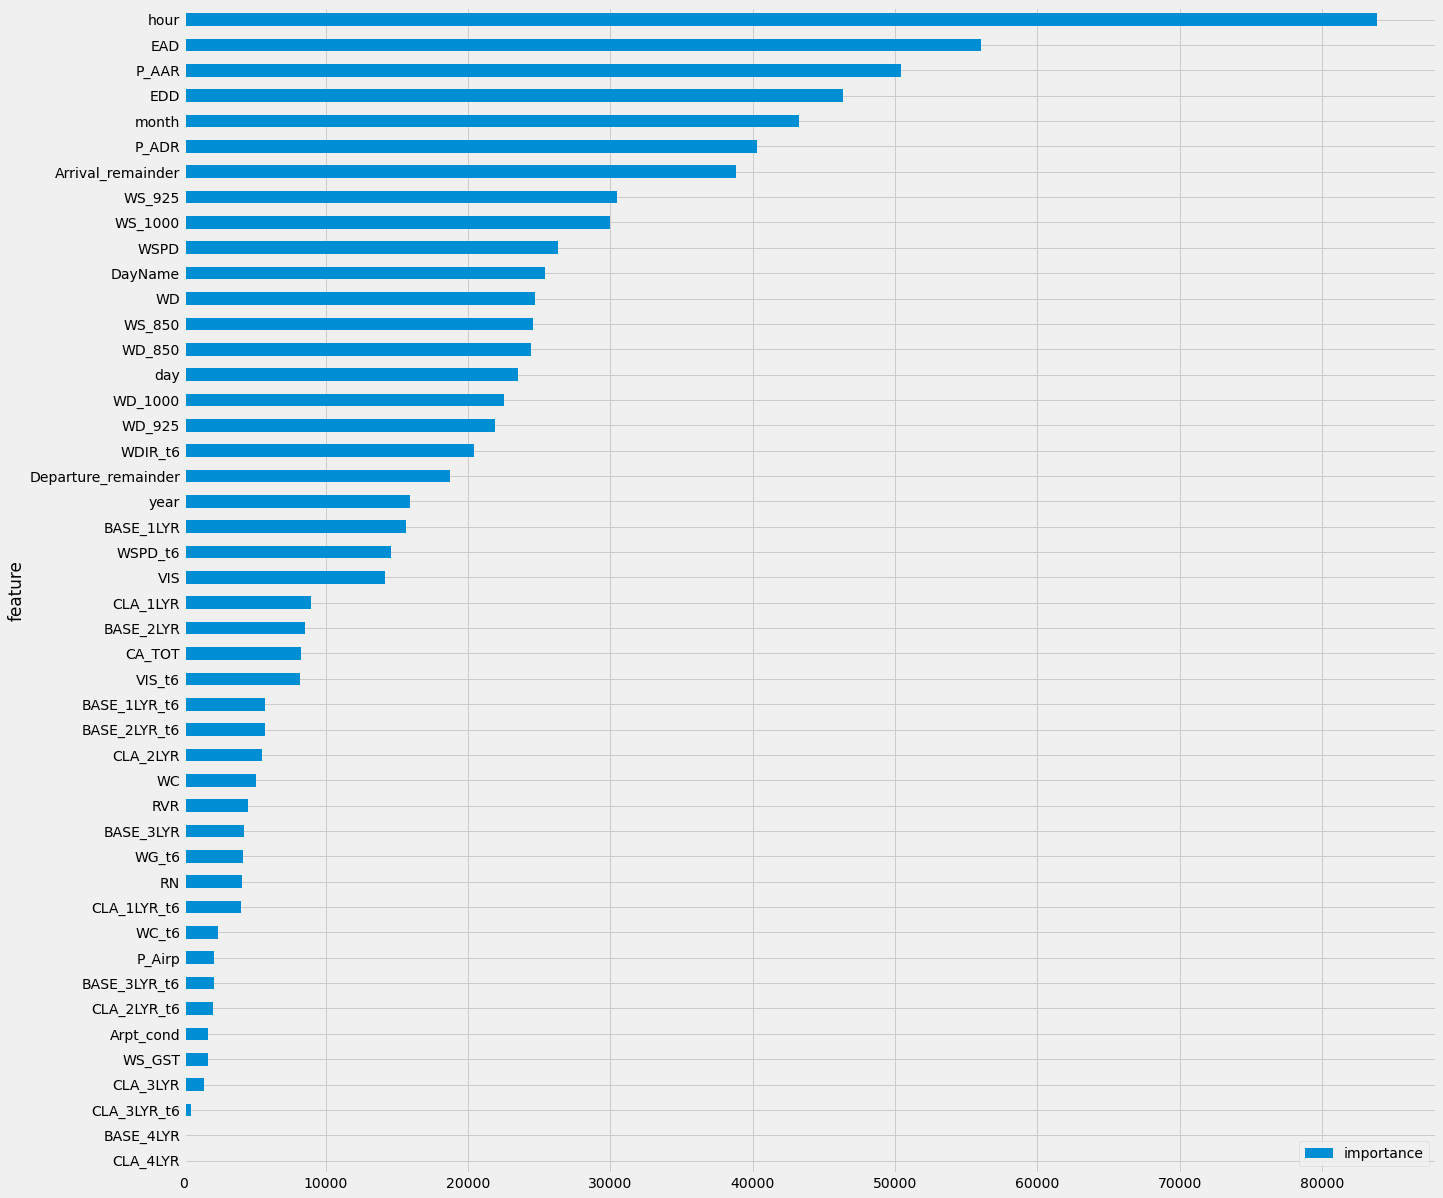

In [23]:
# Feature Importance
imp = pd.DataFrame({'feature': Data_m.columns, 'importance': reg_arrival.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize = (20,20))
plt.legend(loc='lower right')

In [ ]:
plot_metric(reg_arrival, figsize=(10,10))

In [ ]:
# AAR - pred
pred_test_a = Data_raw.drop('ADR', axis=1)
pred_test_a['pred_a'] = reg_arrival.predict(pred_test_a.drop('AAR', axis=1))
sns.pairplot(data=pred_test_a, vars=['AAR','pred_a'], size=10, plot_kws={'alpha': .5}, kind ='scatter' )

In [ ]:
# Test
Test_all = Test(Data_raw, ops='arrival', start = 0, end = 8760).sort_values('Difference')
Test_all['Difference'].abs().sort_values(ascending=False).head(30)

In [ ]:
Test(Data_raw, ops='arrival', start = 0, end = 8760)

-------------------
## Departure

In [ ]:
# Predict & Evaluation
print(f'Total RMSE : {np.sqrt(mean_squared_error(y_d, reg_departure.predict(X_d))):.4f}')

print(f'Training R^2 : {r2_score(y_train_d, reg_departure.predict(X_train_d)) :.4f}')
print(f'Test R^2 : {r2_score(y_test_d, reg_departure.predict(X_test_d)) :.4f}')

print(f'Training RMSE : {np.sqrt(mean_squared_error(y_train_d, reg_departure.predict(X_train_d))):.4f}')
print(f'Test RMSE : {np.sqrt(mean_squared_error(y_test_d, reg_departure.predict(X_test_d))):.4f}')

In [ ]:
# Feature Importance
imp = pd.DataFrame({'feature': Data_m.columns, 'importance': reg_departure.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize = (20,20))
plt.legend(loc='lower right')

In [ ]:
plot_metric(reg_departure, figsize=(10,10))

In [ ]:
# ADR - pred
pred_test_d = Data_raw.drop('AAR', axis=1)
pred_test_d['Prediction_departure'] = reg_departure.predict(pred_test_d.drop('ADR', axis=1))
sns.pairplot(data=pred_test_d, vars=['ADR','Prediction_departure'], size=10, plot_kws={'alpha': .5})

In [ ]:
#############################################################################################################
#############################################################################################################
#############################################################################################################

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


sns.scatterplot(data = pred_test_d, x = "ADR", y = "Prediction_departure" , ax = ax1)
sns.distplot(pred_test_d["ADR"], label = 'ADR', kde = False, ax = ax2)
sns.distplot(pred_test_d["Prediction_departure"], label = 'Prediction', kde = False, ax = ax2)

ax1.set(xlabel='Actual Departure Rate', ylabel='Departure Prediction')
ax2.set(xlabel='Departures per hour', ylabel='Count')
#ax1.set_title('aaa')
#ax2.set_title('bbb')

plt.legend()
plt.show()

#############################################################################################################
#############################################################################################################
#############################################################################################################

In [ ]:
# Test
Test_all = Test(Data_raw, ops='departure', start = 0, end = 8760).sort_values('Difference')
Test_all['Difference'].abs().sort_values(ascending=False).head(30)

***
***
***

# Maximum Capacity

In [ ]:
"""

# 예전 버전 : 원래 demand부터 시작 -> extra demand를 더함

def max_capacity(Data_raw, Data_m, example):   
    
    # extra
    extra_demand = 50
    
    # arrival
    data_a = Data_m.to_numpy()[example:example+1]
    XX_a = np.zeros((1,len(data_a.T)))
    for i in range(extra_demand+1):
        XX_a = np.append(XX_a, data_a, axis = 0)
        XX_a[i,0] = XX_a[i,0] + i-1
    XXX_a = XX_a[1:extra_demand+1]
    XXXX_a = np.arange(XXX_a[0,0], XXX_a[extra_demand-1,0]+1, 1)
    YYYY_a = reg_arrival.predict(XXX_a[0:extra_demand+1])
    max_aar = float(max(YYYY_a))
    actual_aar = int(Data_raw['AAR'][example:example+1])
    ead = int(Data_raw['EAD'][example:example+1])
    prediction_a = float(reg_arrival.predict(Data_m[example:example+1]))
    
    # departure
    data_d = Data_m.to_numpy()[example:example+1]
    XX_d = np.zeros((1,len(data_d.T)))
    for i in range(extra_demand+1):
        XX_d = np.append(XX_d, data_d, axis = 0)
        XX_d[i,2] = XX_d[i,2] + i-1
    XXX_d = XX_d[1:extra_demand+1]
    XXXX_d = np.arange(XXX_d[0,2], XXX_d[extra_demand-1,2]+1, 1)
    YYYY_d = reg_departure.predict(XXX_d[0:extra_demand+1])
    max_adr = float(max(YYYY_d))
    actual_adr = int(Data_raw['ADR'][example:example+1])
    edd = int(Data_raw['EDD'][example:example+1])
    prediction_d = float(reg_departure.predict(Data_m[example:example+1])) 

    # Total
    result_ = pd.DataFrame({'EAD' : XXXX_a ,'Predicted AAR' : YYYY_a, 'EDD' : XXXX_d ,'Predicted ADR' : YYYY_d, 
                            'Demand' : XXXX_a + YYYY_a, 'Capacity' : YYYY_a + YYYY_d})
    
    # plot
    plt.figure(figsize=(15,15))
    plt.title('Maximum Capacity', fontsize=30)
    plt.xlabel('Estimated Demands', fontsize=25)
    plt.ylabel('Capacity', fontsize=25)
    plt.plot(XXXX_a, YYYY_a, label = 'Arrival')
    plt.plot(XXXX_d, YYYY_d, label = 'Departure')
    plt.plot(XXXX_a[:-15]+XXXX_d[:-15], YYYY_a[:-15] + YYYY_d[:-15], label = 'Total')   # 안 예뻐서 뒤에 15개 자름
    plt.legend(prop={'size': 20})
    ax = plt.subplot()
    plt.text(0.95, 0.04,    # 위치조정
             f"""
             * Predicted Max AAR: {max_aar:.3f}\n
               Predicted AAR : {prediction_a:.3f}\n
               Actual AAR : {actual_aar} \n               
               EAD : {ead} \n\n
             
             * Predicted Max ADR: {max_adr:.3f}\n
               Predicted ADR : {prediction_d:.3f}\n
               Actual ADR : {actual_adr} \n               
               EDD : {edd} \n\n
             
             * Predicted Max Capacity: {max_aar + max_adr:.3f}\n
               Predicted Rate : {prediction_a + prediction_d:.3f}\n
               Actual Rate : {actual_aar + actual_adr} \n               
               Demand : {ead + edd}'
             """,
             fontsize=15, style='italic', transform=ax.transAxes, bbox={'facecolor': 'grey', 'alpha': 0, 'pad': 5})
    plt.show()    
    return result_
    
"""

In [ ]:
# *** training data에는 AAR, ADR 둘다 없어야 함
# 0부터 시작
# max capacity 선 추가
# 원래 demand에 대한 predict 점 추가

def max_capacity(Data_raw, Data_m, example):    # 50까지 늘림
    
    # extra
    demand = 80
    

    # arrival
    data_a = Data_m.to_numpy()[example:example+1]
    XX_a = np.zeros((1,len(data_a.T)))
    
    original_demand_a = int(data_a[0][0])
    for i in range(0,demand+1):
        XX_a = np.append(XX_a, data_a, axis = 0)
        XX_a[i,0] = XX_a[i,0] + i - original_demand_a
    
    XX_a[0] = XX_a[1]   
    XX_a[0,0] = 0   
    XXX_a = XX_a[0:demand+1]
    XXXX_a = np.arange(XXX_a[0,0], XXX_a[demand,0]+1, 1)
    YYYY_a = reg_arrival.predict(XXX_a[0:demand+1])
    max_aar = float(max(YYYY_a))
    actual_aar = int(Data_raw.drop('ADR', axis=1)['AAR'][example:example+1])
    ead = int(Data_raw.drop('ADR', axis=1)['EAD'][example:example+1])
    prediction_a = float(reg_arrival.predict(Data_m[example:example+1]))
    
    
    
    # departure
    data_d = Data_m.to_numpy()[example:example+1]
    XX_d = np.zeros((1,len(data_d.T)))
    
    original_demand_d = int(data_d[0][1])
    for i in range(0,demand+1):
        XX_d = np.append(XX_d, data_d, axis = 0)
        XX_d[i,1] = XX_d[i,1] + i - original_demand_d
        
    XX_d[0] = XX_d[1]           
    XX_d[0,1] = 0
    XXX_d = XX_d[0:demand+1]
    XXXX_d = np.arange(XXX_d[0,1], XXX_d[demand,1]+1, 1)
    YYYY_d = reg_departure.predict(XXX_d[0:demand+1])
    max_adr = float(max(YYYY_d))
    actual_adr = int(Data_raw.drop('AAR', axis=1)['ADR'][example:example+1])
    edd = int(Data_raw.drop('AAR', axis=1)['EDD'][example:example+1])
    prediction_d = float(reg_departure.predict(Data_m[example:example+1])) 

    
    
    # capacity - arrival과 departure을 수요의 비율로 늘렸을 때
    max_cap = int(max(Data_raw['AAR'] + Data_raw['ADR']))
    max_capacity = np.zeros(demand+1)
    for i in range(0,demand*2+1,2):
        if round(i*data_a[0,0]/(data_a[0,0]+data_d[0,1])) >=75:
            capa_arr = YYYY_a[75]
        elif round(i*data_d[0,1]/(data_a[0,0]+data_d[0,1])) >=75:
            capa_dep = YYYY_d[75]
        else:
            capa_arr = YYYY_a[round(i*data_a[0,0]/(data_a[0,0]+data_d[0,1]))]
            capa_dep = YYYY_d[round(i*data_d[0,1]/(data_a[0,0]+data_d[0,1]))]
        max_capacity[int(i/2)] = capa_arr + capa_dep
    
    
    
    # plot
    plt.figure(figsize=(15,15))
    plt.title('Maximum Capacity', fontsize=30)
    plt.xlabel('Estimated Demands', fontsize=25)
    plt.ylabel('Capacity', fontsize=25)
    ax = plt.subplot()

    plt.plot(XXXX_a, YYYY_a, label = 'Arrival')    # Arrival
    plt.plot(XXXX_d, YYYY_d, label = 'Departure')    # Departure
    plt.plot(XXXX_a[:-5] + XXXX_d[:-5], max_capacity[:-5], label = 'Total')    # Capacity - 안 예뻐서 뒤에 55개 자름
    plt.plot(XXXX_a[:-5]+XXXX_d[:-5], [max_cap]*(demand-4), label = f'Empirical Maximum = {max_cap}')    # 데이터 상 max capacity
    
    plt.plot(data_a[0,0], prediction_a,'ob', markersize = 10)    # 원래 arrival 예측값
    plt.plot(data_d[0,1], prediction_d,'or', markersize = 10)    # 원래 departure 예측값
    plt.plot(data_a[0,0]+data_d[0,1], prediction_a + prediction_d,'yo', markersize = 15)    # 원래 capacity 예측값
    plt.legend(prop={'size': 20}, loc = 'upper left')

    plt.text(0.95, 0.04,    # 위치조정
             f"""
             * Predicted Max AAR: {max_aar:.1f}\n
               Predicted AAR : {prediction_a:.1f}\n
               Actual AAR : {actual_aar} \n               
               EAD : {ead} \n\n
             
             * Predicted Max ADR: {max_adr:.1f}\n
               Predicted ADR : {prediction_d:.1f}\n
               Actual ADR : {actual_adr} \n               
               EDD : {edd} \n\n
             
             * Predicted Max Capacity: {max_aar + max_adr:.1f}\n
               Predicted Rate : {prediction_a + prediction_d:.1f}\n
               Actual Rate : {actual_aar + actual_adr} \n               
               Demand : {ead + edd}'
             """,
             fontsize=15, style='italic', transform=ax.transAxes, bbox={'facecolor': 'grey', 'alpha': 0, 'pad': 5})
    
    plt.show()   
    
    return Data_raw[example:example+1]   #result_

In [ ]:
# 원하는 시간의 Max Capacity 그래프

max_capacity(Data_raw, Data_m, 154)     # 숫자에 원하는 Data index(0-8760) 넣기

< Notable Samples> 

* pd.DataFrame(Data_raw).idxmax()             # 각 column별 max값의 index

AAR 최소 : 2 <br>
AAR 최대 : 1481 <br>
EAD 최대 : 641 <br>
ADR 최소 : 28 <br>
ADR 최대 : 538 <br>
EDD 최대 : 273 <br>
Total Rate(AAR+ADR) 최대(77) : 5703 <br>
Total Demand(EAD+EDD) 최대(70) : 4814 <br><br>

Arrival_reaminder 최대 : 5992 <br>
Departure_remainder 최대 : 8242 <br><br>

WSPD 최대 : 5990 <br>
W_GST 최대 : 5990 <br>
시정 최소 : 1755 <br>
Ceiling 최소 : 321 <br>
RVR 최소 1448 <br><br>

TAF WSPD 최대 : 5988 <br>
TAF W_GST 최대 : 5988 <br>
TAF 시정 최소 : 319 <br>
TAF Ceiling 최소 : 10?? <br>

In [ ]:
# Data : 불러온 파일
# Data_temp : 일단 필요 없어 보이는 column을 버린 것
# data_taf : dictinoary 안에 Data_6 - Data_24 전부 넣은 것
# Data_6, Data_12 .. : 해당 시간 전의 TAF만 있고, 나머지 시간의 TAF는 버린 것
# Data_raw : Data_#과 동일
# Data_m : Data_# 에서 AAR, ADR 뺀 것
# Data_a : Data_m 로 바꿈
# Data_d : Data_m 로 바꿈

***
***
***

# 추가 실험

##  왜 AAR에서 중간이 비는가?

In [ ]:
a = reg_arrival.predict(X_a)
np.rint(a)        # 반올림하고 정수로 만듦
pd.DataFrame(np.rint(a)).value_counts().sort_index()

In [ ]:
# AAR수 별로 정렬
Data['AAR'].value_counts().sort_index()

In [ ]:
# 12에서 16으로 예측한 날들 표시
pred = pd.DataFrame({'pred' :reg_arrival.predict(Data_m)})
pred_low = pred[(pred['pred'] < 16) & (pred['pred'] >= 12)].index
Data.loc[pred_low]

***
***
***

# 모델 저장

In [ ]:
import joblib

lgbr_a = "../evaluate/lgbr_a.pkl"
lgbr_d = "../evaluate/lgbr_d.pkl"
joblib.dump(reg_arrival, lgbr_a)
joblib.dump(reg_departure, lgbr_d)

In [ ]:
# extra
demand = 80
example = 10

# arrival
data_a = Data_m.to_numpy()[example:example+1]
XX_a = np.zeros((1,len(data_a.T)))

In [ ]:
# Data_m = data_arrival
date = Data_m[example:example+1]
date = datetime.datetime(date['year'][example], date['month'][example], date['day'][example], date['hour'][example])

In [ ]:
original_demand_a = int(data_a[0][0])
for i in range(0,demand+1):
    XX_a = np.append(XX_a, data_a, axis = 0)
    XX_a[i,0] = XX_a[i,0] + i - original_demand_a

XX_a[0] = XX_a[1]   
XX_a[0,0] = 0   
XXX_a = XX_a[0:demand+1]
XXXX_a = np.arange(XXX_a[0,0], XXX_a[demand,0]+1, 1)
YYYY_a = reg_arrival.predict(XXX_a[0:demand+1])
max_aar = float(max(YYYY_a))
actual_aar = int(Data_raw.drop('ADR', axis=1)['AAR'][example:example+1])
ead = int(Data_raw.drop('ADR', axis=1)['EAD'][example:example+1])
prediction_a = float(reg_arrival.predict(Data_m[example:example+1]))



# departure
data_d = Data_m.to_numpy()[example:example+1]
XX_d = np.zeros((1,len(data_d.T)))

original_demand_d = int(data_d[0][1])
for i in range(0,demand+1):
    XX_d = np.append(XX_d, data_d, axis = 0)
    XX_d[i,1] = XX_d[i,1] + i - original_demand_d

XX_d[0] = XX_d[1]           
XX_d[0,1] = 0
XXX_d = XX_d[0:demand+1]
XXXX_d = np.arange(XXX_d[0,1], XXX_d[demand,1]+1, 1)
YYYY_d = reg_departure.predict(XXX_d[0:demand+1])
max_adr = float(max(YYYY_d))
actual_adr = int(Data_raw.drop('AAR', axis=1)['ADR'][example:example+1])
edd = int(Data_raw.drop('AAR', axis=1)['EDD'][example:example+1])
prediction_d = float(reg_departure.predict(Data_m[example:example+1])) 



# capacity - arrival과 departure을 수요의 비율로 늘렸을 때
max_cap = int(max(Data_raw['AAR'] + Data_raw['ADR']))
max_capacity = np.zeros(demand+1)
for i in range(0,demand*2+1,2):
    if round(i*data_a[0,0]/(data_a[0,0]+data_d[0,1])) >=75:
        capa_arr = YYYY_a[75]
    elif round(i*data_d[0,1]/(data_a[0,0]+data_d[0,1])) >=75:
        capa_dep = YYYY_d[75]
    else:
        capa_arr = YYYY_a[round(i*data_a[0,0]/(data_a[0,0]+data_d[0,1]))]
        capa_dep = YYYY_d[round(i*data_d[0,1]/(data_a[0,0]+data_d[0,1]))]
    max_capacity[int(i/2)] = capa_arr + capa_dep



# plot
plt.figure(figsize=(15,15))
plt.title('Maximum Capacity', fontsize=30)
plt.xlabel('Estimated Demands', fontsize=25)
plt.ylabel('Capacity', fontsize=25)
ax = plt.subplot()

plt.plot(XXXX_a, YYYY_a, label = 'Arrival')    # Arrival
plt.plot(XXXX_d, YYYY_d, label = 'Departure')    # Departure
plt.plot(XXXX_a[:-5] + XXXX_d[:-5], max_capacity[:-5], label = 'Total')    # Capacity - 안 예뻐서 뒤에 55개 자름
plt.plot(XXXX_a[:-5]+XXXX_d[:-5], [max_cap]*(demand-4), label = f'Empirical Maximum = {max_cap}')    # 데이터 상 max capacity

plt.plot(data_a[0,0], prediction_a,'ob', markersize = 10)    # 원래 arrival 예측값
plt.plot(data_d[0,1], prediction_d,'or', markersize = 10)    # 원래 departure 예측값
plt.plot(data_a[0,0]+data_d[0,1], prediction_a + prediction_d,'yo', markersize = 15)    # 원래 capacity 예측값
plt.legend(prop={'size': 20}, loc = 'upper left')

plt.text(0.95, 0.04,    # 위치조정
         f"""
         * Predicted Max AAR: {max_aar:.1f}\n
           Predicted AAR : {prediction_a:.1f}\n
           Actual AAR : {actual_aar} \n               
           EAD : {ead} \n\n

         * Predicted Max ADR: {max_adr:.1f}\n
           Predicted ADR : {prediction_d:.1f}\n
           Actual ADR : {actual_adr} \n               
           EDD : {edd} \n\n

         * Predicted Max Capacity: {max_aar + max_adr:.1f}\n
           Predicted Rate : {prediction_a + prediction_d:.1f}\n
           Actual Rate : {actual_aar + actual_adr} \n               
           Demand : {ead + edd}'
         """,
         fontsize=15, style='italic', transform=ax.transAxes, bbox={'facecolor': 'grey', 'alpha': 0, 'pad': 5})

plt.show()   